In [99]:
from data_load_utils import load_labs_and_vitals
import numpy as np
import pandas as pd
import os
from datetime import datetime
import pickle
from time import time
from os.path import join as pjoin

In [ ]:
os.chdir('../../')
os.listdir()

# Cohort

In [2]:
#when you play around with data locally set this to path where everything is stored
PATH_TO_QUERY_DATA = "/scratch/gobi2/kingsley/irl_nodegam/mimic_preproc/query-data/"
# PATH_TO_CLEANED_DATA = "/scratch/gobi2/kingsley/irl_nodegam/mimic_preproc/model-data/"
# PATH_TO_CLEANED_DATA = "/scratch/gobi2/kingsley/irl_nodegam/mimic_preproc/model-data2/"
PATH_TO_CLEANED_DATA = "/scratch/gobi2/kingsley/irl_nodegam/mimic_preproc/model-data3/"

os.makedirs(PATH_TO_CLEANED_DATA, exist_ok=True)

pd.set_option("display.max_columns",101)
pd.set_option("display.max_rows",101)

###########
#params for dataset construction

#default thresholds we'll use throughout, so not explicitly in filenames (for brevity)
LOS_LOWER_THRESH = 12 #exclude if LOS is shorter than this many hours
LOS_CAP = 72 #last time point considered, if longer than this cap here & end traj 
#(will take last decision a bit before this final time, eg an hour prior)
MIN_MAP_THRESH = 0 #must have at least this many measured MAP values to be retained

#this is a much harsher filter, may want to play around with this one...
# this filter is only applied to files with 'Xbpleq65' in the filename
MAP_FILTER_THRESH = 65
MAP_NUM_BELOW_THRESH = 0 #must have at least this many MAP values below MAP_FILTER_THRESH to be retained

MIN_ACTION_NUM = 2 # For each patient at least have this number of actions to avoid too many empty action

# The discretization window. Use 1 hour as interval. So starting from start_time, the 0-1 hour is the first idx etc
# Note we follow the paper which MDP starts in 1 hour after ICU INTIME.
DISCRETIZE_WINDOW = 2

#NOTE: in this newer version of the data cleaning, there is 
#  no longer a hard start on first decision time to be at hour 1, or on hourly spacing
#
# DANGER! If you are expecting your data to be on an hourly grid, this does NOT do that!

#TODO: eventually later on might implement different args for some of these design choices
BP_AGG_FUNC = 'min' #'min'; how to aggregate BP values to get a single value...
BASELINE_IMPUTE_METHOD = 'median' #for now the only option is population median, but maybe improve later
TIMESERIES_IMPUTE_METHOD = 'last' #for now the only option is sample-and-hold or last-one-carry-forward

SEED = 8675309 #seed for reproducing any results that involve randomness
np.random.seed(SEED)

##########
########## load in the baseline/static data for the cohort
##########

cohort_dat = pd.read_csv(PATH_TO_QUERY_DATA+'cohort.csv')

# do any additional filtering beyond cohort construction, if desired...

cohort_dat = cohort_dat.loc[cohort_dat['LOS'] >= LOS_LOWER_THRESH,:]

print('cohort loaded')

cohort loaded


# Time-series data load

In [3]:
##########
########## LOAD all time series data
##########

all_ts_dats, ts_medians, all_ts_vars = load_labs_and_vitals(PATH_TO_QUERY_DATA,cohort_dat)

print('time series variables all loaded')

###########
########### all vital/lab values have been loaded; preprocessing of most extreme values
###########


dbp
fio2


/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


GCS
hr
map
sbp
spontaneousrr


/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


spo2
temp
urine
weight
bun


/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


magnesium


/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


platelets
sodium
alt
hct
po2
ast
potassium
wbc
bicarbonate
creatinine


/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


lactate
pco2
bilirubin_total
glucose


/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (5,7) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


inr
hgb
time series variables all loaded!
time series variables clipped to plausible ranges, outliers removed
time series variables all loaded


In [4]:
# VERBOSE = True
# LOWER_Q = 0
# UPPER_Q = 100

In [5]:
# for v in all_ts_vars:
# 	dat = all_ts_dats[v]
# 	if 'GCS' not in v: 
# 		if VERBOSE:
# 			print(v)
#         #some manual clips for certain vars
# 		vals = np.array(dat['VALUE'],"float")
# 		if v=='map':
# 			dat.loc[vals<=40,'VALUE'] = 40 #implausible
# 		if v=='sbp':
# 			dat.loc[vals<=60,'VALUE'] = 60 #implausible
# 		if v=='dbp':
# 			dat.loc[vals<=30,'VALUE'] = 30 #implausible		
# 		if v=='gfr':
# 			dat.loc[vals>=100,'VALUE'] = 100 #GFR doesn't really mean anything when that high		

# Extract actions

## Setup

In [6]:
# Not sure what the variable FINAL_ICU_IDS is.
# Just take all cohort ids from the cohort_dat
# From the POPCORN paper, they mention:
#   We only filtered by the first ICU stay for hospital stays that had multiple ICU admits, (NOTE: it has been done already in cohort.csv)
#   and then filtered to ICU stays with 3 or more MAP measurements less than 65mmHg. And should have 10142 ICU stays
final_ICU_IDs = cohort_dat['ICUSTAY_ID'].sort_values().unique()

In [7]:
final_ICU_IDs.shape

(21583,)

In [8]:
###################
################### load in & process all actions. NOTE that times vary across trajectories now!
###################
#load in data; actions are already sorted by icu_id & start_time
fluids_dat = pd.read_csv(PATH_TO_QUERY_DATA+'allfluids_and_bloodproducts_mv.csv')
fluids_dat['STARTTIME'] = pd.to_datetime(fluids_dat['STARTTIME'])
fluids_dat['ENDTIME'] = pd.to_datetime(fluids_dat['ENDTIME'])

#filter & threshold
fluids_dat['AMOUNT'] += 1 #rounding edge cases
fluids_dat = fluids_dat.loc[fluids_dat['AMOUNT'] >= 250, :] #cut tiny fluids
#TODO: why is pandas throwing warning?
fluids_dat['AMOUNT'][fluids_dat['AMOUNT']>=2000] = 2000


vaso_dat = pd.read_csv(PATH_TO_QUERY_DATA+'vasopressors_mv.csv')
vaso_dat['STARTTIME'] = pd.to_datetime(vaso_dat['STARTTIME'])
vaso_dat['ENDTIME'] = pd.to_datetime(vaso_dat['ENDTIME'])

#threshold; don't filter bc *any* pressor on is a big deal, unlike fluids
vaso_dat['RATE_NORMED_NOREPI'][vaso_dat['RATE_NORMED_NOREPI']>=2.5] = 2.5

map_dat = pd.read_csv(PATH_TO_QUERY_DATA+'map.csv')
# Some NAN in ICUSTAY_ID. Remove NaN and make ICUSTAY_ID as int
map_dat = map_dat[~pd.isnull(map_dat['ICUSTAY_ID'])]
map_dat['ICUSTAY_ID'] = map_dat['ICUSTAY_ID'].astype(int)
map_dat = map_dat.sort_values('ICUSTAY_ID')
map_dat['CHARTTIME'] = pd.to_datetime(map_dat['CHARTTIME'])

#cache for speedup
# I do not know what final_ICU_IDs are. So I would just use these dataframe's ICU ids
# So I will only keep patients that have at least 1 fluids or vaso, and they are in the cohort_dat
# final_ICU_IDs = pd.concat([vaso_dat['ICUSTAY_ID'], fluids_dat['ICUSTAY_ID'], map_dat['ICUSTAY_ID']]).unique()
# final_ICU_IDs = final_ICU_IDs[np.in1d(final_ICU_IDs, cohort_dat['ICUSTAY_ID'])]


fluid_starts = fluids_dat['ICUSTAY_ID'].searchsorted(final_ICU_IDs,'left')
fluid_ends = fluids_dat['ICUSTAY_ID'].searchsorted(final_ICU_IDs,'right')
vaso_starts = vaso_dat['ICUSTAY_ID'].searchsorted(final_ICU_IDs,'left')
vaso_ends = vaso_dat['ICUSTAY_ID'].searchsorted(final_ICU_IDs,'right')
map_starts = map_dat['ICUSTAY_ID'].searchsorted(final_ICU_IDs,'left')
map_ends = map_dat['ICUSTAY_ID'].searchsorted(final_ICU_IDs,'right')


###### NOTE: probably not a bad idea to filter to *ONLY* ICU IDs that at least take *some* sort of action...??
###	or at the very least, either have: 
###		- 1+ non-null action, OR
###		- many (5+...?) low MAPs that are < 65...

/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
## My own code to make them work
pop_dat = cohort_dat.set_index('ICUSTAY_ID').loc[final_ICU_IDs].reset_index()
pop_dat['INTIME'] = pd.to_datetime(pop_dat['INTIME'])
pop_dat['OUTTIME'] = pd.to_datetime(pop_dat['OUTTIME'])
pop_dat['ADMITTIME'] = pd.to_datetime(pop_dat['ADMITTIME'])

### Main loop

In [10]:
#buffer to give at end of trajetory to assess effect of terminal action 
#UPDATE: this is implicit now by using last MAP as terminating time, and 
#	so last action will be last tx before then...
# END_BUFFER = 1

#buffer around "sick" times, where if no explicit treatment for this long before or after
# a "sick" time, then the "sick" time should be treated as an intentional "dont treat" action
#
# 	define: "very sick" patient to be someone with a MAP of < 60...if MAP is that low and no tx, 
#	we will assume that this was an intentional "dont treat" action...
# TODO: also may want this to depend on lactate...?? or other markers of acuity?
SICK_TIME_BUFFER = 1.01
MAP_SICK_THRESH = 65 #criteria for "sick"...for now...

#if been this many hours or more between other action times (either tx or explicit no-tx), 
#  add an extra action in for explicit no-action, since even "healthy" in ICU is being
#  monitored fairly regularly...
# LONG_GAP_TIME = 4.01



def total_pressor_normed_amount(start_t,end_t,v_starts,v_ends,v_rates):
	# get total amount of pressor in specified period [t_start,t_end]
	# normalized by size of period
	# TODO: vectorize & speedup...?

	delta_t = end_t - start_t

	#integrate total pressors given this period, catching all edge cases
	pressor_amt = 0
	for v_s, v_e, r in zip(v_starts,v_ends,v_rates):
		if v_s >= start_t and v_e <= end_t:
			pressor_amt += r*60*(v_e-v_s)		
		if v_s < start_t and v_e > end_t:
			pressor_amt += r*60*delta_t
		if v_s < start_t and v_e > start_t and v_e <= end_t:
			pressor_amt += r*60*(v_e-start_t)
		if v_s >= start_t and v_s < end_t and v_e > end_t:
			pressor_amt += r*60*(end_t-v_s)

	pressor_normed_amt = 1/delta_t*pressor_amt
	return pressor_normed_amt


#first pass we go through and grab all the raw action amounts & times, then discretize
all_rawaction_data = {}


loop_t = time()
for ID_ind,ID in enumerate(final_ICU_IDs):
	if ID_ind % 100 == 99:
		print("processing %d/%d, took %.2f" %(ID_ind+1,len(final_ICU_IDs),time()-loop_t))
		loop_t = time()

	# get ICU start time, out time, & LOS 
	this_pop_dat = pop_dat.iloc[ID_ind]
	start_time = this_pop_dat['INTIME']
	outtime = this_pop_dat['OUTTIME']
	total_time = (outtime-start_time).total_seconds()/60/60

	#either discharge from ICU or capped length (for now 2 days)	
	# NOTE take off some time at very end to give us a buffer,
	# and allow us to assess the effect of the last action taken...
	# we will artifically force last decision time to be here, at very latest
	end_time = min(total_time,LOS_CAP)

	#get MAP values & times to help inform grid...
	s = map_starts[ID_ind]
	e = map_ends[ID_ind]
	this_maps = map_dat[s:e]
	map_times = np.array((this_maps['CHARTTIME'] - start_time).astype('timedelta64[m]').astype(float))/60
	map_vals = np.array(this_maps['VALUENUM'])

	#filter to before end...
	map_inds = np.logical_and(map_times <= end_time, map_times >= 0)
	map_times = map_times[map_inds]
	map_vals = map_vals[map_inds]

	#skip IDs with very few MAPs taken
	if len(map_vals) < MIN_MAP_THRESH:
		continue
    
    #skip IDs with very few (< 3) abnormal MAPs
	if len(map_vals[map_vals <= MAP_FILTER_THRESH]) <= MAP_NUM_BELOW_THRESH:
		continue

	#UPDATE our terminating time so that last MAP is where we cut things off...
	end_time = np.max(map_times)

	##### get treatment info for this patient

	#fluids
	s = fluid_starts[ID_ind]
	e = fluid_ends[ID_ind]
	this_fdat = fluids_dat[s:e]

	f_starts = np.array((this_fdat['STARTTIME'] - start_time).astype('timedelta64[m]').astype(float))/60
	f_amounts = np.array(this_fdat['AMOUNT'])

	#filter irrelevant fluids
	f_ind = f_starts < end_time
	f_starts = f_starts[f_ind]
	f_amounts = f_amounts[f_ind]

	#pressors
	s = vaso_starts[ID_ind]
	e = vaso_ends[ID_ind]
	this_vdat = vaso_dat[s:e]
	
	v_starts = np.array((this_vdat['STARTTIME'] - start_time).astype('timedelta64[m]').astype(float))/60
	v_ends = np.array((this_vdat['ENDTIME'] - start_time).astype('timedelta64[m]').astype(float))/60
	v_rates = np.array(this_vdat['RATE_NORMED_NOREPI'])

	#filter irrelevant pressors
	v_ind = v_starts < end_time
	v_starts = v_starts[v_ind]
	v_ends = v_ends[v_ind]
	v_rates = v_rates[v_ind]
	v_ends[v_ends > end_time] = end_time #also force pressors to end, at latest, at our artifical end

	### Step 1: we need to get decision times for building this trajectory,
	### 	start by getting all times when treatment decisions were made:
	###			- pressor started
	###			- pressor ended
	###			- fluid started (end irrelevant bc short)

# 	all_tx_times = np.unique(np.concatenate([f_starts,v_starts,v_ends])) 
# 	all_tx_times = all_tx_times[all_tx_times < end_time] #only allow tx actions before end buffer

# 	### Step 2: expressly filter out tx start times where no MAP between treatments: 
# 	### 	it is assumed safe to combine actions in this window, since action would not have been
# 	### 	updated by a new MAP, so nothing funny about why follow-up action taken...
# 	filtered_tx_times = []
# 	if len(all_tx_times) > 0: #only makes sense if tx actually done...

# 		#start with first tx start
# 		filtered_tx_times.append(all_tx_times[0])

# 		last_t = all_tx_times[0] 
# 		for t in all_tx_times[1:]: 
# 			#iterate forward & check if a new MAP btw last tx and next one
# 			if np.any(np.logical_and(map_times>=last_t, map_times<=t)):
# 				filtered_tx_times.append(t)
# 			last_t = t
# 	filtered_tx_times = np.array(filtered_tx_times)

# 	### Step 3: get the set of all times where patient is "very sick", and no tx
# 	###		given either shortly before (i.e. they're working on it already...),
# 	###		or shortly after (they see this update & change/start tx as appropriate)
# 	### TODO: better way to get sick times than just MAP <= 60?

# 	very_sick_times = np.unique(map_times[map_vals <= MAP_SICK_THRESH])
# 	for t in very_sick_times:
# 		diffs = filtered_tx_times - t #how far is this sick_time from nearest tx

# 		#next tx (or sick-time) from this "bad" measurement is "far away"...
# 		# then treat this new no-action as intentional
# 		#NOTE: don't need explicit logic to handle edge case where filtered_tx_times is empty
# 		if np.all(np.abs(diffs) > SICK_TIME_BUFFER):
# 			filtered_tx_times = np.concatenate([filtered_tx_times,[t]])

# 	#again filter out from very end & sort
# 	filtered_tx_times = filtered_tx_times[filtered_tx_times < end_time]
# 	filtered_tx_times = np.unique(filtered_tx_times)

# 	### Step 4: Fill in last holes so there's an action 
# 	### 	(or no-tx) done at least every 4 hours...

# 	no_sick_gap_times = []

# 	#add in extra times at very beginning & end to catch edge cases
# 	tx_sick_times_extended = np.unique(np.concatenate([[0],filtered_tx_times,[end_time]]))
# 	diffs = tx_sick_times_extended[1:] - tx_sick_times_extended[:-1]
# 	maxdiff = np.max(diffs)

# 	while maxdiff > LONG_GAP_TIME:
# 		### find max diff; 
# 		max_ind = np.where(diffs==maxdiff)[0][0] #doesn't matter if many just grab first

# 		### add midpoint time between these two far apart times...
# 		new_time = (tx_sick_times_extended[max_ind]+tx_sick_times_extended[max_ind+1])/2
# 		tx_sick_times_extended = np.unique(np.concatenate([tx_sick_times_extended,[new_time]]))
# 		no_sick_gap_times.append(new_time)

# 		#keep going until all gaps are small enough...
# 		diffs = tx_sick_times_extended[1:] - tx_sick_times_extended[:-1]
# 		maxdiff = np.max(diffs)

# 	##### yay, we now have a final set of action times for our time discretization.
# 	#####     now, add up all tx amounts for the action times to actually compute actions...

# 	#add in 0 & end_time even though not explicitly an action; 
# 	#need to get the tx amounts per period for edge cases each end,
# 	# even if not explicitly modeling as action...
# 	final_action_times = np.unique(np.concatenate([[0],filtered_tx_times,no_sick_gap_times,[end_time]]))


    ###### Ok the original code does special time discretization. In my RL, I just need to have a simple
    ###### grid-point discretization of time points. These would avoid uneven gaps between time points.
    ###### We also follow POPCORN-POMDP paper to use 72 hour with 1 hour as grid point
    ###### So at most 71 actions (0-1, 1-2, 2-3, ..., 70-71) and the last observation is (71-72)
    ###### If end_time is 45.6 (the last MAP time), then it should be 46.
# 	final_action_times = np.arange(0, int(np.ceil(end_time)), DISCRETIZE_WINDOW)
	final_action_times = np.arange(0, end_time + DISCRETIZE_WINDOW, DISCRETIZE_WINDOW)


	### ok, now collect up the action amounts...

	#tricky so use helper func
	pressor_normed_amts = []
	for (t0,t1) in zip(final_action_times[:-1],final_action_times[1:]):
		amt = total_pressor_normed_amount(t0,t1,v_starts,v_ends,v_rates)
		pressor_normed_amts.append(amt)
	pressor_normed_amts.append(np.nan) #none at end; not tracking anything after terminal end_time

	#more straightforward; not integrating, just treat as point mass with no timing
	fluid_amts = []
	for (t0,t1) in zip(final_action_times[:-1],final_action_times[1:]):
		fluid_inds = np.logical_and(f_starts >= t0, f_starts < t1)
		fluid_amts.append(np.sum(f_amounts[fluid_inds]))
	fluid_amts.append(np.nan)

	############ 

	actions_dat = pd.DataFrame()
	actions_dat['Times'] = final_action_times
	actions_dat['Vasopressor_normed_amt'] = np.array(pressor_normed_amts)
	actions_dat['Total_fluid_bolus_amt'] = np.array(fluid_amts)

	### SAVE
	all_rawaction_data[ID] = actions_dat

processing 100/21583, took 0.30
processing 200/21583, took 0.31
processing 300/21583, took 0.30
processing 400/21583, took 0.32
processing 500/21583, took 0.31
processing 600/21583, took 0.30
processing 700/21583, took 0.31
processing 800/21583, took 0.29
processing 900/21583, took 0.31
processing 1000/21583, took 0.31
processing 1100/21583, took 0.31
processing 1200/21583, took 0.31
processing 1300/21583, took 0.28
processing 1400/21583, took 0.29
processing 1500/21583, took 0.30
processing 1600/21583, took 0.31
processing 1700/21583, took 0.31
processing 1800/21583, took 0.29
processing 1900/21583, took 0.31
processing 2000/21583, took 0.31
processing 2100/21583, took 0.28
processing 2200/21583, took 0.30
processing 2300/21583, took 0.29
processing 2400/21583, took 0.32
processing 2500/21583, took 0.32
processing 2600/21583, took 0.32
processing 2700/21583, took 0.30
processing 2800/21583, took 0.30
processing 2900/21583, took 0.30
processing 3000/21583, took 0.31
processing 3100/215

Filter out patients with too few actions

In [11]:
from collections import Counter


fluid_count, vaso_count, total, pat_count = Counter(), Counter(), Counter(), 0
final_ICU_IDs = []
for ID in all_rawaction_data:
    actions_dat = all_rawaction_data[ID].iloc[:-1] # Ignore the last time
    
    if (np.sum(actions_dat['Vasopressor_normed_amt'] > 0) + np.sum(actions_dat['Total_fluid_bolus_amt'] > 0)) < MIN_ACTION_NUM:
        continue
    final_ICU_IDs.append(ID)

In [12]:
all_rawaction_data = {the_id: v for the_id, v in all_rawaction_data.items() if the_id in final_ICU_IDs}

In [13]:
len(final_ICU_IDs), len(all_rawaction_data)

(9404, 9404)

In [14]:
# tmp = iter(all_rawaction_data)
# all_rawaction_data[next(tmp)]

In [15]:
# Save the data
# pickle.dump(all_rawaction_data,open(PATH_TO_CLEANED_DATA+'all_raw_actions_times.p','wb'))
# all_rawaction_data = pickle.load(open(path_to_model_data+'all_raw_actions_times.p','rb'))

# filtered down cohort slightly...
final_ICU_IDs = np.sort(np.array(list(all_rawaction_data.keys())))
#update pop_dat to account for filtering from stays with few MAPs...
pop_dat = pop_dat.loc[np.in1d(pop_dat['ICUSTAY_ID'],final_ICU_IDs),:]

assert final_ICU_IDs.shape[0] == pop_dat.shape[0]

In [16]:
### test actions btw 0 & actual first action_time...
# all_fluids = []
# all_pressors = []
# for ID in final_ICU_IDs:
# 	actions_dat = all_rawaction_data[ID]
# 	first_act = actions_dat.iloc[0]

# 	all_fluids.append(first_act['Total_fluid_bolus_amt'])
# 	all_pressors.append(first_act['Vasopressor_normed_amt'])

# all_fluids = np.array(all_fluids)
# all_pressors = np.array(all_pressors)

# print('fluid counts for 0 - first time')
# print(np.unique(all_fluids,return_counts=True))
# print('pressor counts for 0 - first time')
# print(np.unique(all_pressors,return_counts=True))

# ok, so only about 0.5% of time is there an action btw 0 & first flagged action time we have...
# ignore and these won't be modeled explicitly w RL but will at least inform states 
# when we aggregate some features based on past tx amounts given...
# TODO: what the fuck, how/why is this edge case happening...

In [17]:
all_vasos, all_fluids = [], []
for ID, df in all_rawaction_data.items():
    all_vasos.append(df['Vasopressor_normed_amt'].values[:-1])
    all_fluids.append(df['Total_fluid_bolus_amt'].values[:-1])
all_vasos = np.concatenate(all_vasos)
all_fluids = np.concatenate(all_fluids)

In [18]:
all_fluids.shape

(262578,)

In [19]:
all_fluids[all_fluids > 0].shape

(34748,)

In [20]:
np.percentile(all_fluids[all_fluids > 0], [25, 50, 75])

array([ 501.      ,  564.999996, 1001.      ])

In [21]:
np.percentile(all_fluids[all_fluids > 0], [33, 67])

array([ 501., 1001.])

In [22]:
# fluid_cutoffs = [0,499, 1001, 1e8] #5 bins. Follow the paper
fluid_cutoffs = [0,500,1000,1e8] #4 bins
for s, e in zip(fluid_cutoffs[:-1], fluid_cutoffs[1:]):
    tmp = all_fluids[(all_fluids > s) & (all_fluids <= e)]
    print(len(tmp), np.median(tmp), np.mean(tmp))

7395 284.000002 300.30927639839086
12274 501.0 544.3773703547337
15079 1001.0 1367.073567145381


In [23]:
vaso_cutoffs = [0,8.1,21.58,1e8] #4 bins based on 33.3/66.7% quantiles of nonzeros
for s, e in zip(vaso_cutoffs[:-1], vaso_cutoffs[1:]):
    tmp = all_vasos[(all_vasos > s) & (all_vasos <= e)]
    print(len(tmp), np.median(tmp), np.mean(tmp))

32622 3.0016175342399998 3.3990797284196494
21311 13.5004500981 13.807471534664234
18039 37.81202866749998 50.69195364399738


(0, 2000)

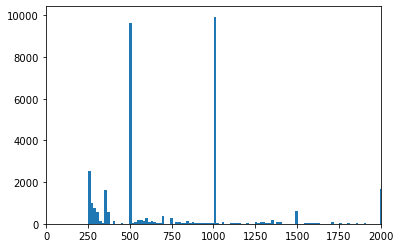

In [24]:
import matplotlib.pyplot as plt
plt.hist(all_fluids[all_fluids > 0], bins=1000)
plt.xlim(0, 2000)

'done'

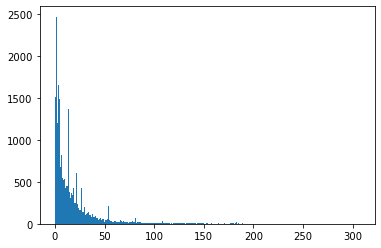

In [25]:
import matplotlib.pyplot as plt
plt.hist(all_vasos[all_vasos > 0], bins=1000)
'done'
# plt.xlim(0, 2000)

In [26]:
########## ok, now let's discretize actions into bins...

fluid_cutoffs = [0,500,1000,1e8] #4 bins
vaso_cutoffs = [0,8.1,21.58,1e8] #4 bins based on 33.3/66.7% quantiles of nonzeros

EPS = 1e-8
FLUIDS_BINS = np.array(fluid_cutoffs)+EPS; FLUIDS_BINS[0] = 0
VASO_BINS = np.array(vaso_cutoffs)+EPS; VASO_BINS[0] = 0

NUM_VASO_BINS = len(VASO_BINS) #4
NUM_FLUID_BINS = len(FLUIDS_BINS) #4
#in overall numbering, we'll have 0 = no action; 1 = dose 1 of fluids, 0 vaso; 
# 2 = dose 2 of fluids, 0 vaso; ... ; F = max fluids, 0 vaso; F+1 = 0 fluids, 1 vaso, ... 
NUM_ACTIONS = NUM_VASO_BINS*NUM_FLUID_BINS

def vaso_fluid_to_bin(fluids,vasos):
	f_ids = np.searchsorted(FLUIDS_BINS,fluids)
	v_ids = np.searchsorted(VASO_BINS,vasos)

	overall_ids = f_ids + NUM_FLUID_BINS*v_ids

	return f_ids,v_ids,overall_ids


##### ok group raw action amounts...almost done...

all_actions_disc_data = {}

loop_t = time()
for ID_ind,ID in enumerate(final_ICU_IDs):
	if ID_ind % 100 == 99:
		print("processing %d/%d, took %.2f" %(ID_ind+1,len(final_ICU_IDs),time()-loop_t))
		loop_t = time()

	dat = all_rawaction_data[ID]

	fluids = np.array(dat['Total_fluid_bolus_amt'])
	vasos = np.array(dat['Vasopressor_normed_amt'])

	f_ids,v_ids,overall_ids = vaso_fluid_to_bin(fluids,vasos)
	f_ids[-1] = v_ids[-1] = overall_ids[-1] = -999 #no last action

	dat['OVERALL_ACTION_ID'] = overall_ids
	dat['FLUID_ID'] = f_ids
	dat['VASO_ID'] = v_ids

	all_actions_disc_data[ID] = dat

# pickle.dump(all_actions_disc_data,open(PATH_TO_CLEANED_DATA+'all_disc-v4f4_actions_times.p','wb'))
# all_actions_disc_data = pickle.load(open(PATH_TO_CLEANED_DATA+'all_disc-v4f4_actions_times.p','rb'))

processing 100/9404, took 0.10
processing 200/9404, took 0.08
processing 300/9404, took 0.08
processing 400/9404, took 0.08
processing 500/9404, took 0.08
processing 600/9404, took 0.08
processing 700/9404, took 0.08
processing 800/9404, took 0.08
processing 900/9404, took 0.08
processing 1000/9404, took 0.08
processing 1100/9404, took 0.08
processing 1200/9404, took 0.08
processing 1300/9404, took 0.08
processing 1400/9404, took 0.08
processing 1500/9404, took 0.08
processing 1600/9404, took 0.08
processing 1700/9404, took 0.08
processing 1800/9404, took 0.08
processing 1900/9404, took 0.08
processing 2000/9404, took 0.08
processing 2100/9404, took 0.08
processing 2200/9404, took 0.08
processing 2300/9404, took 0.08
processing 2400/9404, took 0.08
processing 2500/9404, took 0.08
processing 2600/9404, took 0.08
processing 2700/9404, took 0.08
processing 2800/9404, took 0.08
processing 2900/9404, took 0.08
processing 3000/9404, took 0.08
processing 3100/9404, took 0.08
processing 3200/9

In [27]:
#get overall action cts
all_actions_disc = []
for ID in final_ICU_IDs:
	acts = np.array(all_actions_disc_data[ID]['OVERALL_ACTION_ID'])[1:-1]
	all_actions_disc.append(acts)
all_actions_disc = np.concatenate(all_actions_disc)

action_cts = np.unique(all_actions_disc,return_counts=True)
for a,c in zip(action_cts[0],action_cts[1]):
	print(a,c,c/len(all_actions_disc)*100)

0 164200 64.85658084953431
1 4724 1.8659104015420223
2 7533 2.975424016684178
3 6695 2.644426362896664
4 25373 10.021961180847955
5 913 0.36062154881622915
6 1860 0.7346725967121427
7 3138 1.2394637680014535
8 16906 6.677620924739506
9 652 0.25753039411629947
10 1201 0.47437730572649645
11 2150 0.849218324156509
12 14058 5.55270288418242
13 733 0.2895242007473121
14 1118 0.4415935285613847
15 1920 0.758371712735115


In [28]:

def rolling_sum(vec,k=8):
	res = np.cumsum(np.array(vec,"float"))
	res[k:] -= res[:-k]
	return res

loop_t = time()
for ID_ind,ID in enumerate(final_ICU_IDs):
	if ID_ind % 100==99:
		print("processing %d/%d, took %.2f" %(ID_ind+1,len(final_ICU_IDs),time()-loop_t))
		loop_t = time()

	actions_dat = all_actions_disc_data[ID]

	### off by 1 here; the prev/last vars should be 0 initially, and then drop the last one...
	z = np.zeros(actions_dat.shape[0])

	actions_dat['total_all_prev_vasos'] = z
	actions_dat['total_all_prev_vasos'][1:] = np.cumsum(np.array(actions_dat['Vasopressor_normed_amt'],"float"))[:-1]
	actions_dat['total_all_prev_fluids'] = z
	actions_dat['total_all_prev_fluids'][1:] = np.cumsum(np.array(actions_dat['Total_fluid_bolus_amt'],"float"))[:-1]
	actions_dat['total_last_8hrs_vasos'] = z
	actions_dat['total_last_8hrs_vasos'][1:] = rolling_sum(actions_dat['Vasopressor_normed_amt'], 8 // DISCRETIZE_WINDOW)[:-1]
	actions_dat['total_last_8hrs_fluids'] = z
	actions_dat['total_last_8hrs_fluids'][1:] = rolling_sum(actions_dat['Total_fluid_bolus_amt'], 8 // DISCRETIZE_WINDOW)[:-1]
    
	assert 8 % DISCRETIZE_WINDOW == 0, 'DISCRETIZED window can not whole divide the 8 hours. Should choose other number of hours'

	all_actions_disc_data[ID] = actions_dat

# pickle.dump(all_actions_disc_data,open(PATH_TO_CLEANED_DATA+'all_disc-v4f4_actions_times_prevactions.p','wb'))
# all_actions_disc_data = pickle.load(open(PATH_TO_CLEANED_DATA+'all_disc-v4f4_actions_times_prevactions.p','rb'))

/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/scratch/gobi1/kingsley/envs/cu101/lib/p

processing 100/9404, took 0.26
processing 200/9404, took 0.26
processing 300/9404, took 0.26
processing 400/9404, took 0.26
processing 500/9404, took 0.26
processing 600/9404, took 0.26
processing 700/9404, took 0.26
processing 800/9404, took 0.26
processing 900/9404, took 0.26
processing 1000/9404, took 0.26
processing 1100/9404, took 0.26
processing 1200/9404, took 0.26
processing 1300/9404, took 0.26
processing 1400/9404, took 0.26
processing 1500/9404, took 0.26
processing 1600/9404, took 0.26
processing 1700/9404, took 0.26
processing 1800/9404, took 0.26
processing 1900/9404, took 0.26
processing 2000/9404, took 0.26
processing 2100/9404, took 0.26
processing 2200/9404, took 0.26
processing 2300/9404, took 0.26
processing 2400/9404, took 0.26
processing 2500/9404, took 0.26
processing 2600/9404, took 0.26
processing 2700/9404, took 0.26
processing 2800/9404, took 0.26
processing 2900/9404, took 0.26
processing 3000/9404, took 0.26
processing 3100/9404, took 0.26
processing 3200/9

In [29]:
this_pop_dat

ICUSTAY_ID                                 299998
HADM_ID                                    158288
SUBJECT_ID                                  69587
INTIME                        2181-07-05 18:47:40
OUTTIME                       2181-07-07 17:24:38
ADMITTIME                     2181-07-05 07:15:00
DISCHTIME                     2181-08-03 16:03:00
DOB                           2094-07-21 00:00:00
DOD                           2183-02-25 00:00:00
DOD_HOSP                                      NaN
DOD_SSN                       2183-02-25 00:00:00
DEATHTIME                                     NaN
HOSPITAL_EXPIRE_FLAG                            0
GENDER                                          M
ADMISSION_TYPE                           ELECTIVE
ADMISSION_LOCATION      PHYS REFERRAL/NORMAL DELI
DISCHARGE_LOCATION       REHAB/DISTINCT PART HOSP
INSURANCE                                Medicare
LANGUAGE                                     ENGL
RELIGION                                 CATHOLIC


In [30]:
########## yay lets do states already


all_state_data = {}

baseline_cov_names = ['age','is_F','surg_ICU','is_not_white',
	'is_emergency','is_urgent','hrs_from_admit_to_icu']

#cache cutpoints in sorted dataframes in advance, much faster
starts_ts = {}; ends_ts = {}
for v in all_ts_vars:
	dat = all_ts_dats[v]
	starts_ts[v] = dat['ICUSTAY_ID'].searchsorted(final_ICU_IDs,'left')
	ends_ts[v] = dat['ICUSTAY_ID'].searchsorted(final_ICU_IDs,'right')


loop_t = time()
for ID_ind,ID in enumerate(final_ICU_IDs):
	if ID_ind % 100==99:
		print("processing %d/%d, took %.2f" %(ID_ind+1,len(final_ICU_IDs),time()-loop_t))
		loop_t = time()

	###############
	#static vars first
	this_pop_dat = pop_dat.iloc[ID_ind]
	start_time = this_pop_dat['INTIME']
	outtime = this_pop_dat['OUTTIME']
	total_time = (outtime-start_time).total_seconds()/60/60

	#build out all static vars
	age = float(this_pop_dat['AGE'])
	if age > 90: age = 90 #BUG: tons of ages are 300!! will screw up standardization
	if np.isnan(age): age = pop_dat['AGE'].median()

	is_F = int(this_pop_dat['GENDER']=='F')
	if np.isnan(is_F): is_F = 0

	icu_type = this_pop_dat['FIRST_CAREUNIT']
	surg_ICU = int(icu_type=='CSRU' or icu_type=='SICU' or icu_type=='TSICU')

	ethn = this_pop_dat['ETHNICITY']
	is_not_white = 0
	if 'WHITE' not in ethn: is_not_white = 1

	admit_type = this_pop_dat['ADMISSION_TYPE']
	is_emergency = 0
	is_urgent = 0
	if admit_type=='EMERGENCY': is_emergency=1
	if admit_type=='URGENT': is_urgent=1

	hrs_from_admit_to_icu = (this_pop_dat['INTIME']-this_pop_dat['ADMITTIME']).total_seconds()/60/60
	if hrs_from_admit_to_icu<0: hrs_from_admit_to_icu = 0 #weird edge case

	baseline_covs = np.array([age,is_F,surg_ICU,
		is_not_white,is_emergency,is_urgent,hrs_from_admit_to_icu])

	###############
	##### figure out time stamps
	this_act_dat = all_actions_disc_data[ID]

	#drop initial action time; just so we can get (rare) initial actions
	grid_times = np.array(this_act_dat['Times'])[1:] 
	n_t = len(grid_times)
	n_dec = n_t - 1 #no action taken at very last time point; used for final transition & reward


	###############
	### state variables

	states_dat = pd.DataFrame()
	states_dat['Times'] = grid_times
	states_dat['normed_time'] = grid_times/LOS_CAP

	#add baseline data in first
	for var,val in zip(baseline_cov_names,baseline_covs):
		states_dat[var] = val


	#####
	#now build out the time series
	#also build out indicator vector at each time, noting whether var was imputed or not
	for v in all_ts_vars:
		s = starts_ts[v][ID_ind]
		e = ends_ts[v][ID_ind]
		this_dat = all_ts_dats[v][s:e]
		this_t = np.array((this_dat['CHARTTIME'] - start_time).astype('timedelta64[m]').astype(float))/60
		if v=='urine':
			val_str = 'VALUE'
		else:
			val_str = 'VALUENUM'
		this_vals = np.array(this_dat[val_str])

		#impute anything initially missing with pop median, then
		#fill this in with observed values via LOCF
		imputed_vals = ts_medians[v]*np.ones(n_t)

		### Now get LOCF for cts labs/vitals
        ### Just take the first measurement within that interval!
		tt = np.searchsorted(grid_times+1e-8,this_t)
		
		for i in range(len(tt)):
			if i!=len(tt)-1:
				imputed_vals[tt[i]:tt[i+1]] = this_vals[i] 
			else:
				imputed_vals[tt[i]:] = this_vals[i] 
		
		#EXCEPT: for MAP/SBP/DBP, we fill in with the worst in the window
		#	this only applies to windows in which *more* than 1 MAP is measured.
		#	after these windows, the LOCF kicks in with the most recent value from them
		if v in ['map','sbp','dbp']:
			u_tt = np.unique(tt)
			starts = np.searchsorted(tt,u_tt,'left')
			ends = np.searchsorted(tt,u_tt,'right')
			for t,s,e in zip(u_tt,starts,ends):
				if t>=0 and t<n_t: 
					imputed_vals[t] = np.min(this_vals[s:e])

		#get indicators for at which times the variable was actually sampled
		inds_samples_vals = np.zeros(n_t+1) #edge case when values past endtime
		inds_samples_vals[tt] = 1.0
		inds_samples_vals = inds_samples_vals[:-1] #edge case when values past endtime

		states_dat[v] = imputed_vals
		states_dat[v+'_ind'] = inds_samples_vals

	#last, combine the 3 GCS vars & then toss the individuals
	states_dat['GCS'] = states_dat['GCS_eye']+states_dat['GCS_motor']+states_dat['GCS_verbal']
	states_dat['GCS_ind'] = states_dat['GCS_eye_ind']+states_dat['GCS_motor_ind']+states_dat['GCS_verbal_ind']
	states_dat['GCS_ind'] = np.minimum(1,states_dat['GCS_ind'])

	#also drop GFR indicator since same as creat
	states_dat = states_dat.drop(['GCS_eye','GCS_motor','GCS_verbal','GCS_eye_ind',
		'GCS_motor_ind','GCS_verbal_ind'],axis=1)

	all_state_data[ID] = states_dat

processing 100/9404, took 3.85
processing 200/9404, took 3.91
processing 300/9404, took 3.91
processing 400/9404, took 3.88
processing 500/9404, took 3.94
processing 600/9404, took 3.89
processing 700/9404, took 3.90
processing 800/9404, took 3.89
processing 900/9404, took 3.90
processing 1000/9404, took 3.90
processing 1100/9404, took 3.94
processing 1200/9404, took 3.89
processing 1300/9404, took 3.90
processing 1400/9404, took 3.95
processing 1500/9404, took 3.93
processing 1600/9404, took 3.92
processing 1700/9404, took 3.89
processing 1800/9404, took 3.91
processing 1900/9404, took 3.91
processing 2000/9404, took 3.89
processing 2100/9404, took 3.87
processing 2200/9404, took 3.89
processing 2300/9404, took 3.91
processing 2400/9404, took 3.92
processing 2500/9404, took 3.93
processing 2600/9404, took 4.06
processing 2700/9404, took 3.91
processing 2800/9404, took 3.91
processing 2900/9404, took 3.88
processing 3000/9404, took 3.91
processing 3100/9404, took 3.87
processing 3200/9

In [31]:
# pickle.dump(all_state_data,open(PATH_TO_CLEANED_DATA+'all_states.p','wb'))
# all_state_data = pickle.load(open(PATH_TO_CLEANED_DATA+'all_states.p','rb'))

The following is the reward

In [32]:
############
############ setup rewards for each ICU stay
############

def lin_reward_func(bps,cutoffs=[40,55,60,65],vals=[-1,-0.15,-0.05,0]): 
	return np.interp(bps,cutoffs,vals)
# xx = np.linspace(40,75,1000); plt.plot(xx,np.log(1+lin_reward_func(xx)+1e-8)); plt.show()
# xx = np.linspace(40,75,1000); plt.plot(xx,lin_reward_func(xx)); plt.show()

all_reward_data = {}

URINE_OUTPUT_THRESH = 30 #if urine is above this, we're not too worried about BP if it's above 55
MAP_UO_THRESH = 55 #as long as MAP is above this, give max reward as long as UO is ok

for ID in final_ICU_IDs:

	s_dat = all_state_data[ID]

	times = np.array(s_dat['Times'])[:-1] #last state doesn't have reward, no action (just use state to compute reward)
	
	bps = np.array(s_dat['map'])[1:] #first bp reading not used for reward; bp_t, take a_t, r_t = f(bp_t+1)
	rewards = lin_reward_func(bps)

	#extra mask to ensure UO measured, if not measured yet, treat as if bad.
	# don't want to give a free pass to slightly low MAPs that we got
	# before a UO was measured
	uos = np.array(s_dat['urine'])
	uo_inds = np.array(s_dat['urine_ind'])
	if np.all(uo_inds==0):
		uos *= 0
	else:
		first_meas_uo = np.where(uo_inds==1)[0][0]
		uos[:first_meas_uo] = 0
	#ok, now that fixed initial UOs, cut to one ahead for rewards...
	uos = uos[1:]

	good_inds = np.logical_and(uos >= URINE_OUTPUT_THRESH, bps >= MAP_UO_THRESH)

	rewards[good_inds] = 0 #moderate hypotension but good UO = ok

	rewards_dat = pd.DataFrame()
	rewards_dat['Times'] = times
	rewards_dat['Rewards'] = rewards

	all_reward_data[ID] = rewards_dat

# pickle.dump(all_reward_data,open(PATH_TO_CLEANED_DATA+'rewards.p','wb'))
# all_reward_data = pickle.load(open(PATH_TO_CLEANED_DATA+'rewards.p','rb'))

In [33]:
##### extend the state space...
##### build out additional indicator variables for labs: 8 hour and ever-measured inds
#####	(no vitals since super frequent as is)


### helper funcs to convert inds at hourly level to other levels
def convert_1inds_to_kinds(ind_vec,times,k=8):
	#NOTE: old func breaks here bc times not hourly...
	n = len(ind_vec)
	assert len(times)==n

	res = np.zeros(n,"float")
	res[0] = ind_vec[0]
	for i in range(1,n):
		this_t = times[i]
		rel_inds = np.logical_and(times >= this_t-k, times <= this_t)
		res[i] = np.any(ind_vec[rel_inds]==1)

	return res

def convert_1inds_to_everinds(ind_vec):
	res = np.cumsum(np.array(ind_vec))
	return np.array(res>=1,"float")

#add in 8hour and ever-measured indicators for these variables (mostly labs, not measured as often)
extra_ind_vars = np.array(['bicarbonate', 'bun', 'creatinine', 'fio2',
       'glucose', 'hct', 'lactate', 'magnesium','platelets', 'potassium', 'sodium', 
       'wbc', 'alt','ast', 'bilirubin_total', 'pco2', 'hgb','inr','pco2', 'po2', 'weight'])

all_extended_states_dat = {}

loop_t = time()
for ID_ind,ID in enumerate(final_ICU_IDs):
	if ID_ind % 100==99:
		print("processing %d/%d, took %.2f" %(ID_ind+1,len(final_ICU_IDs),time()-loop_t))
		loop_t = time()

	states_dat = all_state_data[ID]
	this_times = np.array(states_dat['Times'])
	for v in extra_ind_vars:
		# SLOW!!
		# states_dat[v+'_8ind'] = convert_1inds_to_kinds(states_dat[v+'_ind'],this_times,8)
		states_dat[v+'_everind'] = convert_1inds_to_everinds(states_dat[v+'_ind'])

	acts_dat = all_actions_disc_data[ID]

	#TODO check for off by 1's
	for act_v in range(1,NUM_VASO_BINS):
		states_dat['last_vaso_'+str(act_v)] = np.array(np.array(acts_dat['VASO_ID'])[:-1]==act_v,"float")

	for act_f in range(1,NUM_FLUID_BINS):
		states_dat['last_fluid_'+str(act_f)] = np.array(np.array(acts_dat['FLUID_ID'])[:-1]==act_f,"float")

	states_dat['total_all_prev_vasos'] = np.array(acts_dat['total_all_prev_vasos'])[1:]
	states_dat['total_all_prev_fluids'] = np.array(acts_dat['total_all_prev_fluids'])[1:]
	states_dat['total_last_8hrs_vasos'] = np.array(acts_dat['total_last_8hrs_vasos'])[1:]
	states_dat['total_last_8hrs_fluids'] = np.array(acts_dat['total_last_8hrs_fluids'])[1:]

	all_extended_states_dat[ID] = states_dat

#list of all vars
state_vars = np.array(all_extended_states_dat[final_ICU_IDs[0]].columns)

pickle.dump(all_extended_states_dat,open(PATH_TO_CLEANED_DATA+'all_states_extravars.p','wb'))
# all_state_data = pickle.load(open(PATH_TO_CLEANED_DATA+'all_states_extravars.p','rb'))

processing 100/9404, took 0.99
processing 200/9404, took 0.99
processing 300/9404, took 0.99
processing 400/9404, took 0.99
processing 500/9404, took 0.99
processing 600/9404, took 1.00
processing 700/9404, took 0.99
processing 800/9404, took 0.98
processing 900/9404, took 0.99
processing 1000/9404, took 0.98
processing 1100/9404, took 0.97
processing 1200/9404, took 0.97
processing 1300/9404, took 0.98
processing 1400/9404, took 0.99
processing 1500/9404, took 0.99
processing 1600/9404, took 1.35
processing 1700/9404, took 0.98
processing 1800/9404, took 0.99
processing 1900/9404, took 0.99
processing 2000/9404, took 0.98
processing 2100/9404, took 1.00
processing 2200/9404, took 0.99
processing 2300/9404, took 1.00
processing 2400/9404, took 0.99
processing 2500/9404, took 1.00
processing 2600/9404, took 1.00
processing 2700/9404, took 0.99
processing 2800/9404, took 0.98
processing 2900/9404, took 1.01
processing 3000/9404, took 0.99
processing 3100/9404, took 0.99
processing 3200/9

In [34]:
#############
############# write out as npz for safe loading
#############

all_states_np = []
all_actions_np = []
all_rewards_np = []

for ID in final_ICU_IDs:

	this_s = all_extended_states_dat[ID]
	this_a = all_actions_disc_data[ID]
	this_r = all_reward_data[ID]

	states_np = np.array(this_s)[:,1:] # dim: T+1 x n_S
	act_np = np.array(this_a)[1:-1,3] #dim: T
	rew_np = np.array(this_r)[:,1] # dim: T

	all_states_np.append(states_np)
	all_actions_np.append(act_np)
	all_rewards_np.append(rew_np)


# np.savez(PATH_TO_CLEANED_DATA+'states_actions_rewards_IDs.npz',
# 	all_states=all_states_np,all_actions=all_actions_np,
# 	all_rewards=all_rewards_np,all_IDs=final_ICU_IDs,
# 	state_var_names=state_vars[1:])

### Store the preprocessor

In [100]:
PATH_TO_CLEANED_DATA = "/scratch/gobi2/kingsley/irl_nodegam/mimic_preproc/model-data3/"
all_extended_states_dat = pickle.load(open(PATH_TO_CLEANED_DATA+'all_states_extravars.p','rb'))

In [106]:
all_states = []
for ID in all_extended_states_dat:
	this_states = all_extended_states_dat[ID]
	all_states.append(this_states)
all_states = pd.concat(all_states)

In [107]:
all_states.shape

(262578, 97)

In [108]:
all_states

,Times,normed_time,age,is_F,surg_ICU,is_not_white,is_emergency,is_urgent,hrs_from_admit_to_icu,dbp,dbp_ind,fio2,fio2_ind,hr,hr_ind,map,map_ind,sbp,sbp_ind,spontaneousrr,spontaneousrr_ind,spo2,spo2_ind,temp,temp_ind,urine,urine_ind,weight,weight_ind,bun,bun_ind,magnesium,magnesium_ind,platelets,platelets_ind,sodium,sodium_ind,alt,alt_ind,hct,hct_ind,po2,po2_ind,ast,ast_ind,potassium,potassium_ind,wbc,wbc_ind,bicarbonate,bicarbonate_ind,creatinine,creatinine_ind,lactate,lactate_ind,pco2,pco2_ind,bilirubin_total,bilirubin_total_ind,glucose,glucose_ind,inr,inr_ind,hgb,hgb_ind,GCS,GCS_ind,bicarbonate_everind,bun_everind,creatinine_everind,fio2_everind,glucose_everind,hct_everind,lactate_everind,magnesium_everind,platelets_everind,potassium_everind,sodium_everind,wbc_everind,alt_everind,ast_everind,bilirubin_total_everind,pco2_everind,hgb_everind,inr_everind,po2_everind,weight_everind,last_vaso_1,last_vaso_2,last_vaso_3,last_fluid_1,last_fluid_2,last_fluid_3,total_all_prev_vasos,total_all_prev_fluids,total_last_8hrs_vasos,total_last_8hrs_fluids
0,2.0,0.027778,64.866546,0.0,0.0,0.0,0.0,0.0,7.230556,37.0,1.0,70.0,1.0,68.0,1.0,52.0,1.0,91.0,1.0,28.0,1.0,96.0,1.0,36.277778,1.0,80.0,0.0,84.0,1.0,17.0,1.0,2.0,1.0,131.0,1.0,140.0,1.0,40.0,1.0,30.5,1.0,99.0,1.0,49.0,1.0,3.9,1.0,17.8,1.0,18.0,1.0,1.0,1.0,1.1,1.0,40.0,1.0,0.8,1.0,198.0,1.0,1.5,1.0,10.7,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,6.281986,1076.0,6.281986,1076.0
1,4.0,0.055556,64.866546,0.0,0.0,0.0,0.0,0.0,7.230556,45.0,1.0,70.0,1.0,80.0,1.0,65.0,1.0,112.0,1.0,28.0,1.0,100.0,1.0,36.555556,1.0,43.0,1.0,84.0,0.0,17.0,0.0,2.0,0.0,131.0,0.0,140.0,0.0,40.0,0.0,30.5,0.0,171.0,1.0,49.0,0.0,3.9,0.0,17.8,0.0,17.0,1.0,1.0,0.0,1.3,1.0,32.0,1.0,0.8,0.0,198.0,0.0,1.5,0.0,10.7,0.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,18.292551,1076.0,18.292551,1076.0
2,6.0,0.083333,64.866546,0.0,0.0,0.0,0.0,0.0,7.230556,50.0,1.0,50.0,1.0,84.0,1.0,64.0,1.0,101.0,1.0,25.0,1.0,97.0,1.0,37.666667,1.0,45.0,1.0,84.0,0.0,17.0,0.0,2.0,0.0,131.0,0.0,140.0,0.0,40.0,0.0,30.5,0.0,171.0,0.0,49.0,0.0,3.9,0.0,17.8,0.0,17.0,0.0,1.0,0.0,1.3,0.0,32.0,0.0,0.8,0.0,258.0,1.0,1.5,0.0,10.7,0.0,10.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,30.303116,1076.0,30.303116,1076.0
3,8.0,0.111111,64.866546,0.0,0.0,0.0,0.0,0.0,7.230556,36.0,1.0,50.0,1.0,77.0,1.0,47.0,1.0,74.0,1.0,25.0,1.0,98.0,1.0,37.666667,0.0,17.0,1.0,84.0,0.0,17.0,0.0,2.0,0.0,131.0,0.0,140.0,0.0,40.0,0.0,29.3,1.0,163.0,1.0,49.0,0.0,3.9,0.0,17.8,0.0,17.0,1.0,1.0,0.0,1.3,0.0,30.0,1.0,0.8,0.0,258.0,0.0,1.5,0.0,10.7,0.0,10.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,42.814279,1076.0,42.814279,1076.0
4,10.0,0.138889,64.866546,0.0,0.0,0.0,0.0,0.0,7.230556,45.0,1.0,50.0,0.0,85.0,1.0,61.0,1.0,105.0,1.0,23.0,1.0,98.0,1.0,37.666667,1.0,38.0,1.0,84.0,0.0,17.0,0.0,2.0,0.0,131.0,0.0,140.0,0.0,40.0,0.0,29.3,0.0,115.0,1.0,49.0,0.0,3.9,0.0,17.8,0.0,17.0,1.0,1.0,0.0,1.3,0.0,30.0,1.0,0.8,0.0,258.0,0.0,1.5,0.0,10.7,0.0,10.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,53.952126,1076.0,47.670140,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,38.0,0.527778,86.955998,0.0,0.0,0.0,0.0,0.0,11.544444,55.0,1.0,40.0,0.0,81.0,1.0,76.0,1.0,144.0,1.0,13.0,1.0,97.0,1.0,37.277778,1.0,250.0,1.0,92.6,0.0,20.0,0.0,1.8,0.0,188.0,0.0,141.0,0.0,46.0,0.0,28.2,0.0,168.0,0.0,84.0,0.0,4.1,0.0,11.0,0.0,25.0,0.0,1.0,0.0,2.5,0.0,37.0,0

In [129]:
## These are all features we use for training: note we remove time-related features and the everind since everind is peeking into future
covariates = [
    'age', 'is_F', 'surg_ICU', 'is_not_white',
    'is_emergency', 'is_urgent',
]
features = [
    'dbp', 'fio2', 'hr', 'map', 'sbp', 'spontaneousrr', 'spo2', 'temp',
    'urine', 'weight', 'bun', 'magnesium', 'platelets', 'sodium', 'alt', 'hct', 'po2',
    'ast', 'potassium', 'wbc',
    'bicarbonate', 'creatinine', 'lactate', 'pco2', 'bilirubin_total', 'glucose', 'inr',
    'hgb', 'GCS',
]
features_ind = [f'{f}_ind' for f in features]
# But we provide both number and discretized actions
actions = [
    'last_vaso_1', 'last_vaso_2', 'last_vaso_3',
    'last_fluid_1', 'last_fluid_2', 'last_fluid_3',
    'total_all_prev_vasos', 'total_all_prev_fluids',
    'total_last_8hrs_vasos', 'total_last_8hrs_fluids',
]
all_cols = covariates + features + features_ind + actions

In [128]:
[c for c in all_states.columns if c not in all_cols]

['Times',
 'normed_time',
 'hrs_from_admit_to_icu',
 'bicarbonate_everind',
 'bun_everind',
 'creatinine_everind',
 'fio2_everind',
 'glucose_everind',
 'hct_everind',
 'lactate_everind',
 'magnesium_everind',
 'platelets_everind',
 'potassium_everind',
 'sodium_everind',
 'wbc_everind',
 'alt_everind',
 'ast_everind',
 'bilirubin_total_everind',
 'pco2_everind',
 'hgb_everind',
 'inr_everind',
 'po2_everind',
 'weight_everind']

In [130]:
all_states = all_states[all_cols]

In [131]:
vars_no_processing = ['Times','normed_time','is_F','surg_ICU','is_not_white','is_emergency','is_urgent','last_reward', 'hrs_from_admit_to_icu'
#                       'total_last_8hrs_vasos', 'total_last_8hrs_fluids'
                     ]
cols_norm = [] #normed_time (already scaled); anything with ind; last_vaso_X or last_fluid_X;
for i,v in enumerate(all_states.columns):
	if v in vars_no_processing or 'ind' in v or 'last_fluid' in v or 'last_vaso' in v:
		pass
	else:
		cols_norm.append(v)
		print(v, i)

age 0
dbp 6
fio2 7
hr 8
map 9
sbp 10
spontaneousrr 11
spo2 12
temp 13
urine 14
weight 15
bun 16
magnesium 17
platelets 18
sodium 19
alt 20
hct 21
po2 22
ast 23
potassium 24
wbc 25
bicarbonate 26
creatinine 27
lactate 28
pco2 29
bilirubin_total 30
glucose 31
inr 32
hgb 33
GCS 34
total_all_prev_vasos 70
total_all_prev_fluids 71
total_last_8hrs_vasos 72
total_last_8hrs_fluids 73


Do a qunaitle transform to normal

In [133]:
from lib.mypreprocessor import MyPreprocessor

In [134]:
pp = MyPreprocessor(cols_norm=cols_norm)
pp.fit(all_states)

In [135]:
pp.inverse_transform(pp.transform(all_states))

,age,is_F,surg_ICU,is_not_white,is_emergency,is_urgent,dbp,fio2,hr,map,sbp,spontaneousrr,spo2,temp,urine,weight,bun,magnesium,platelets,sodium,alt,hct,po2,ast,potassium,wbc,bicarbonate,creatinine,lactate,pco2,bilirubin_total,glucose,inr,hgb,GCS,dbp_ind,fio2_ind,hr_ind,map_ind,sbp_ind,spontaneousrr_ind,spo2_ind,temp_ind,urine_ind,weight_ind,bun_ind,magnesium_ind,platelets_ind,sodium_ind,alt_ind,hct_ind,po2_ind,ast_ind,potassium_ind,wbc_ind,bicarbonate_ind,creatinine_ind,lactate_ind,pco2_ind,bilirubin_total_ind,glucose_ind,inr_ind,hgb_ind,GCS_ind,last_vaso_1,last_vaso_2,last_vaso_3,last_fluid_1,last_fluid_2,last_fluid_3,total_all_prev_vasos,total_all_prev_fluids,total_last_8hrs_vasos,total_last_8hrs_fluids
0,64.866546,0.0,0.0,0.0,0.0,0.0,37.0,70.0,68.0,52.0,91.0,28.0,96.0,36.277778,80.0,84.0,17.0,2.0,131.0,140.0,40.0,30.5,99.0,49.0,3.9,17.8,18.0,1.0,1.1,40.0,0.8,198.0,1.5,10.7,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,6.281986,1076.0,6.281986,1076.0
1,64.866546,0.0,0.0,0.0,0.0,0.0,45.0,70.0,80.0,65.0,112.0,28.0,100.0,36.555556,43.0,84.0,17.0,2.0,131.0,140.0,40.0,30.5,171.0,49.0,3.9,17.8,17.0,1.0,1.3,32.0,0.8,198.0,1.5,10.7,7.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,18.292551,1076.0,18.292551,1076.0
2,64.866546,0.0,0.0,0.0,0.0,0.0,50.0,50.0,84.0,64.0,101.0,25.0,97.0,37.666667,45.0,84.0,17.0,2.0,131.0,140.0,40.0,30.5,171.0,49.0,3.9,17.8,17.0,1.0,1.3,32.0,0.8,258.0,1.5,10.7,10.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,30.303116,1076.0,30.303116,1076.0
3,64.866546,0.0,0.0,0.0,0.0,0.0,36.0,50.0,77.0,47.0,74.0,25.0,98.0,37.666667,17.0,84.0,17.0,2.0,131.0,140.0,40.0,29.3,163.0,49.0,3.9,17.8,17.0,1.0,1.3,30.0,0.8,258.0,1.5,10.7,10.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,42.814279,1076.0,42.814279,1076.0
4,64.866546,0.0,0.0,0.0,0.0,0.0,45.0,50.0,85.0,61.0,105.0,23.0,98.0,37.666667,38.0,84.0,17.0,2.0,131.0,140.0,40.0,29.3,115.0,49.0,3.9,17.8,17.0,1.0,1.3,30.0,0.8,258.0,1.5,10.7,10.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,53.952126,1076.0,47.670140,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262573,86.955998,0.0,0.0,0.0,0.0,0.0,55.0,40.0,81.0,76.0,144.0,13.0,97.0,37.277778,250.0,92.6,20.0,1.8,188.0,141.0,46.0,28.2,168.0,84.0,4.1,11.0,25.0,1.0,2.5,37.0,0.6,189.0,1.1,9.2,13.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2503.0,0.000000,0.0
262574,86.955998,0.0,0.0,0.0,0.0,0.0,64.0,40.0,93.0,90.0,168.0,16.0,98.0,37.277778,120.0,92.6,20.0,1.8,188.0,141.0,46.0,28.2,168.0,84.0,4.1,11.0,25.0,1.0,2.5,37.0,0.6,189.0,1.1,9.2,13.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,3504.0,0.000000,1001.0
262575,86.955998,0.0,0.0,0.0,0.0,0.0,65.0,40.0,103.0,90.0,167.0,10.0,96.0,36.888889,190.0,92.6,20.0,1.8,188.0,141.0,46.0,28.2,168.0,84.0,4.1,11.0,25.0,1.0,2.5,37.0,0.6,166.0,1.1,9.2,13.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,3504.0,0.000000,1001.0
262576,86.955998,0.0,0.0,0.0,0.0,0.0,63.0,40.0,101.0,82.0,158.0,18.0,96.0,36.888889,450.0,92.6,20.0,1.8,188.0,141.0,46.0,28.2,168.0,84.0,4.1,11.0,25

In [136]:
all_states

,age,is_F,surg_ICU,is_not_white,is_emergency,is_urgent,dbp,fio2,hr,map,sbp,spontaneousrr,spo2,temp,urine,weight,bun,magnesium,platelets,sodium,alt,hct,po2,ast,potassium,wbc,bicarbonate,creatinine,lactate,pco2,bilirubin_total,glucose,inr,hgb,GCS,dbp_ind,fio2_ind,hr_ind,map_ind,sbp_ind,spontaneousrr_ind,spo2_ind,temp_ind,urine_ind,weight_ind,bun_ind,magnesium_ind,platelets_ind,sodium_ind,alt_ind,hct_ind,po2_ind,ast_ind,potassium_ind,wbc_ind,bicarbonate_ind,creatinine_ind,lactate_ind,pco2_ind,bilirubin_total_ind,glucose_ind,inr_ind,hgb_ind,GCS_ind,last_vaso_1,last_vaso_2,last_vaso_3,last_fluid_1,last_fluid_2,last_fluid_3,total_all_prev_vasos,total_all_prev_fluids,total_last_8hrs_vasos,total_last_8hrs_fluids
0,64.866546,0.0,0.0,0.0,0.0,0.0,37.0,70.0,68.0,52.0,91.0,28.0,96.0,36.277778,80.0,84.0,17.0,2.0,131.0,140.0,40.0,30.5,99.0,49.0,3.9,17.8,18.0,1.0,1.1,40.0,0.8,198.0,1.5,10.7,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,6.281986,1076.0,6.281986,1076.0
1,64.866546,0.0,0.0,0.0,0.0,0.0,45.0,70.0,80.0,65.0,112.0,28.0,100.0,36.555556,43.0,84.0,17.0,2.0,131.0,140.0,40.0,30.5,171.0,49.0,3.9,17.8,17.0,1.0,1.3,32.0,0.8,198.0,1.5,10.7,7.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,18.292551,1076.0,18.292551,1076.0
2,64.866546,0.0,0.0,0.0,0.0,0.0,50.0,50.0,84.0,64.0,101.0,25.0,97.0,37.666667,45.0,84.0,17.0,2.0,131.0,140.0,40.0,30.5,171.0,49.0,3.9,17.8,17.0,1.0,1.3,32.0,0.8,258.0,1.5,10.7,10.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,30.303116,1076.0,30.303116,1076.0
3,64.866546,0.0,0.0,0.0,0.0,0.0,36.0,50.0,77.0,47.0,74.0,25.0,98.0,37.666667,17.0,84.0,17.0,2.0,131.0,140.0,40.0,29.3,163.0,49.0,3.9,17.8,17.0,1.0,1.3,30.0,0.8,258.0,1.5,10.7,10.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,42.814279,1076.0,42.814279,1076.0
4,64.866546,0.0,0.0,0.0,0.0,0.0,45.0,50.0,85.0,61.0,105.0,23.0,98.0,37.666667,38.0,84.0,17.0,2.0,131.0,140.0,40.0,29.3,115.0,49.0,3.9,17.8,17.0,1.0,1.3,30.0,0.8,258.0,1.5,10.7,10.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,53.952126,1076.0,47.670140,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,86.955998,0.0,0.0,0.0,0.0,0.0,55.0,40.0,81.0,76.0,144.0,13.0,97.0,37.277778,250.0,92.6,20.0,1.8,188.0,141.0,46.0,28.2,168.0,84.0,4.1,11.0,25.0,1.0,2.5,37.0,0.6,189.0,1.1,9.2,13.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2503.0,0.000000,0.0
19,86.955998,0.0,0.0,0.0,0.0,0.0,64.0,40.0,93.0,90.0,168.0,16.0,98.0,37.277778,120.0,92.6,20.0,1.8,188.0,141.0,46.0,28.2,168.0,84.0,4.1,11.0,25.0,1.0,2.5,37.0,0.6,189.0,1.1,9.2,13.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,3504.0,0.000000,1001.0
20,86.955998,0.0,0.0,0.0,0.0,0.0,65.0,40.0,103.0,90.0,167.0,10.0,96.0,36.888889,190.0,92.6,20.0,1.8,188.0,141.0,46.0,28.2,168.0,84.0,4.1,11.0,25.0,1.0,2.5,37.0,0.6,166.0,1.1,9.2,13.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,3504.0,0.000000,1001.0
21,86.955998,0.0,0.0,0.0,0.0,0.0,63.0,40.0,101.0,82.0,158.0,18.0,96.0,36.888889,450.0,92.6,20.0,1.8,188.0,141.0,46.0,28.2,168.0,84.0,4.1,11.0,25.0,1.0,2.5,37.0,

In [137]:
with open(pjoin(PATH_TO_CLEANED_DATA, 'pp.pkl'), 'wb') as op:
    pickle.dump(pp, op)

In [61]:
# all_logstate_means = np.mean(np.log(all_states+1.), axis=0)
# all_logstate_sds = np.std(np.log(all_states+1.), axis=0)

In [62]:
# all_logstate_means[inds_to_process]

array([4.18380307, 3.99640221, 3.66302411, 4.45260595, 4.24417694,
       4.67281312, 2.97085573, 4.58376056, 3.63249106, 4.2247309 ,
       4.4011346 , 3.1444602 , 1.1123923 , 5.13699566, 4.93578894,
       3.54112136, 3.43703746, 4.6779852 , 3.82715415, 1.62955128,
       2.45393519, 3.21224337, 0.81776218, 0.97195379, 3.704204  ,
       0.68695684, 4.86675335, 0.87722466, 2.40723144, 2.48586732,
       2.16535488, 6.35382565, 1.08470685, 2.29302736])

In [63]:
# all_logstate_sds[inds_to_process]

array([0.27390952, 0.21056272, 0.4553279 , 0.206643  , 0.18102563,
       0.17614946, 0.31318686, 0.03095234, 0.02153905, 1.15931439,
       0.24822575, 0.64413052, 0.11199065, 0.57282476, 0.03302346,
       0.90029214, 0.15520484, 0.44417858, 0.9160716 , 0.11090469,
       0.49249381, 0.19243921, 0.39652544, 0.33969777, 0.18166662,
       0.50961587, 0.31385633, 0.21266797, 0.15163154, 0.41796691,
       2.2994751 , 2.98275016, 1.71795752, 3.26971166])

In [78]:
# np.savez(PATH_TO_CLEANED_DATA + 'cols_norm_log_mean_std.npz', 
#         mean=all_logstate_means, std=all_logstate_sds)

## Specify train and test idxes

In [64]:
all_states = pickle.load(open(PATH_TO_CLEANED_DATA + 'all_states_extravars.p', 'rb'))

In [65]:
from sklearn.model_selection import train_test_split

In [66]:
all_icustay_ids = list(all_states.keys())
train_ids, test_ids = train_test_split(all_icustay_ids, test_size=0.2, random_state=1356)

In [67]:
len(train_ids), len(test_ids)

(7523, 1881)

In [68]:
with open(PATH_TO_CLEANED_DATA + 'train_icustay_ids.txt', 'w') as op:
    for the_id in train_ids:
        print(the_id, file=op)

In [69]:
with open(PATH_TO_CLEANED_DATA + 'test_icustay_ids.txt', 'w') as op:
    for the_id in test_ids:
        print(the_id, file=op)

In [70]:
pd.read_csv(PATH_TO_CLEANED_DATA + 'train_icustay_ids.txt', header=None).values

array([[262749],
       [209473],
       [229683],
       ...,
       [298152],
       [234961],
       [253359]])

In [71]:
train_ids

[262749,
 209473,
 229683,
 217355,
 237343,
 206312,
 287891,
 215187,
 243327,
 257751,
 293184,
 272810,
 264614,
 202599,
 295714,
 239066,
 209748,
 286228,
 229766,
 245602,
 269658,
 272216,
 225842,
 239588,
 254452,
 273235,
 237196,
 237924,
 296734,
 257678,
 271476,
 259314,
 262270,
 293948,
 219892,
 279673,
 251472,
 264965,
 228700,
 240206,
 288900,
 278306,
 293605,
 285446,
 252068,
 286335,
 256370,
 268472,
 297206,
 239098,
 279210,
 230835,
 274549,
 241993,
 249702,
 282185,
 256141,
 257214,
 213668,
 215010,
 213811,
 285919,
 234745,
 293621,
 253896,
 219717,
 267500,
 218872,
 219628,
 293551,
 216615,
 240081,
 206506,
 277165,
 236992,
 282425,
 267364,
 285889,
 262264,
 249263,
 210041,
 251788,
 283441,
 227603,
 296036,
 256008,
 219687,
 281746,
 282729,
 284945,
 202786,
 251464,
 252178,
 201101,
 266254,
 284535,
 218874,
 210234,
 235030,
 290982,
 242652,
 257991,
 212082,
 264726,
 233796,
 258221,
 280877,
 266832,
 222400,
 283609,
 216962,
 

## Specify 4 other folds for uncertainty estimation

In [138]:
def output_file(path, ids):
    with open(path, 'w') as op:
        for the_id in ids:
            print(the_id, file=op)

In [139]:
train_ids = pd.read_csv(PATH_TO_CLEANED_DATA + 'train_icustay_ids.txt', header=None).values[:, 0]
test_ids = pd.read_csv(PATH_TO_CLEANED_DATA + 'test_icustay_ids.txt', header=None).values[:, 0]

In [142]:
len(train_ids), len(test_ids)

(7523, 1881)

In [74]:
from sklearn.model_selection import KFold

In [149]:
kf = KFold(n_splits=4, shuffle=True, random_state=1356)
for i, (tr_idx, test_idx) in enumerate(kf.split(train_ids)):
    the_tr_ids = train_ids[tr_idx]
    the_test_ids = train_ids[test_idx]
    
    tr_ids = the_tr_ids.tolist() + test_ids.tolist()
    print(len(tr_ids), len(the_test_ids))

    output_file(PATH_TO_CLEANED_DATA + f'train_icustay_ids_{i+1}.txt', tr_ids)
    output_file(PATH_TO_CLEANED_DATA + f'test_icustay_ids_{i+1}.txt', the_test_ids)

7523 1881
7523 1881
7523 1881
7524 1880


In [150]:
the_test_ids

array([209473, 217355, 257751, ..., 275570, 298152, 234961])

In [146]:
!ls $PATH_TO_CLEANED_DATA

all_states_extravars_debug.p  test_icustay_ids_4.txt
all_states_extravars.p	      test_icustay_ids_debug.txt
bc_probs.pkl		      test_icustay_ids.txt
cols_norm_log_mean_std.npz    train_icustay_ids_1.txt
normalized_states_debug.pth   train_icustay_ids_2.txt
normalized_states.pth	      train_icustay_ids_3.txt
pp.pkl			      train_icustay_ids_4.txt
test_icustay_ids_1.txt	      train_icustay_ids_debug.txt
test_icustay_ids_2.txt	      train_icustay_ids.txt
test_icustay_ids_3.txt


In [148]:
pd.read_csv(PATH_TO_CLEANED_DATA + 'test_icustay_ids_1.txt')

,262749
0,237343
1,215187
2,243327
3,239066
4,225842
...,...
1875,280700
1876,213574
1877,240212
1878,239874


## Get a small debug dataset

In [91]:
len(all_states)

9404

In [92]:
# Only subset to 2%, only 300
icuids = list(all_states.keys())[:300]
dset_debug = {k: v for k, v in all_states.items() if k in icuids}

In [96]:
with open(pjoin(PATH_TO_CLEANED_DATA, 'all_states_extravars_debug.p'), 'wb') as fp:
    pickle.dump(dset_debug, fp)

In [97]:
test_ids = icuids[:100]
train_ids = icuids[100:]

In [98]:
with open(pjoin(PATH_TO_CLEANED_DATA, 'test_icustay_ids_debug.txt'), 'w') as fp:
    for the_id in test_ids:
        print(the_id, file=fp)
with open(pjoin(PATH_TO_CLEANED_DATA, 'train_icustay_ids_debug.txt'), 'w') as fp:
    for the_id in train_ids:
        print(the_id, file=fp)